In [149]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import h5py
import tables
import tensorflow as tf
import os
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from get_spectrum import get_spectra

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams["figure.figsize"] = (20,80)

### Function which creates f_esc vs. halo mass scatter plots with a third halo property used for the color scale

- **df_dust**: Dataframe with the runs taking dust into account
- **df_no_dust**: Dataframe which does not take dust into account
- **halo_prop**: List of halo-property keys relative to which the relative escape fraction is plotted 
- **x_axis**: Quantity to be plotted on the x-axis. Usually chosen to be the Halo Mass
- **y_axis**: Quantity to be plotted on the y-axis. With the obvious choice being the escape fraction.
- **titles**: List of titles for the individual plots. Should have the same length as halo_prop. By default no titles are used.
- **norms**: Norms for the color scale. Might be usefull if the colorscales are to be kept consistend across differen plots. By default the norms are determined by the range of the given halo property
- **labels**: Labels for the color scales. By default the corresponding halo_prop key is used
- **lognorm**: Use a logarithmic norm for the colorscale. By default this is set to False
- **relative**: Should the colorscale be normalized by the the median of the quantity

In [226]:
def plot_color_coded(dataframe, halo_prop, x_axis='HaloMass', y_axis='f_esc', 
                     titles=None, norms=None, labels=None, lognorm=False, relative=True):
    
    if x_axis=='HaloMass':
        x_label='Halo Mass [$10^{10}M_{\mathrm{sun}}$]'
    elif x_axis=='StarMass':
        x_label='Stellar Mass [$10^{6}M_{\mathrm{sun}}$]'
    
    figure, subfigs = plt.subplots(2,int(np.ceil(len(halo_prop)/2)))
    if labels==None:
        if relative:
            labels = []
            for prop in halo_prop:
                labels.append(f'{prop}/median({prop})')
        else:
            labels=halo_prop
    for i,prop in enumerate(halo_prop):
        color_data = dataframe.loc[:,prop]#/dataframe[x_axis]
        if relative:
            color_data = color_data/color_data.median()
        if norms == None:
            norm = plt.Normalize(color_data.min(), color_data.max())
        else:
            norm = norms[i]
        if lognorm==True:
            subfig = subfigs[i//2,i%2].scatter(dataframe.loc[:,x_axis], dataframe.loc[:,y_axis], 
                                        c=color_data, s=30, norm=matplotlib.colors.LogNorm())
        else:
            subfig = subfigs[i//2,i%2].scatter(dataframe.loc[:,x_axis], dataframe.loc[:,y_axis], c=color_data,
                                        s=30, norm=norm)
        subfigs[i//2,i%2].set_xscale('log')
        subfigs[i//2,i%2].set_yscale('symlog', linthreshy=1e-3)
        subfigs[i//2,i%2].set_ylim(0.0,1.0)
        
        bar = figure.colorbar(subfig, ax=subfigs[i//2,i%2])
        
        subfigs[i//2,i%2].set_ylabel('$f_{esc}$', size='25')
        bar.set_label(labels[i], fontsize=25)
        #if i==len(halo_prop)-1:
        subfigs[i//2,i%2].set_xlabel(x_label, size='25')
        
        if titles!=None:
            subfigs[i//2,i%2].set_title(titles[i],fontsize=30)
        plt.rcParams["figure.figsize"] = (5*len(halo_prop),5*len(halo_prop))
            
    plt.show();

### A simple function which returns the intersection of the dust and no_dust run dataframes. Since the halos have to overlap in all properties but the scape fraction all these quantities are automatically overlayed

- **df_dust**: Dataframe with the runs taking dust into account
- **df_no_dust**: Dataframe which does not take dust into account

In [5]:
def intersect(df_dust, df_no_dust):
    df_intersect = pd.merge(df_dust, df_no_dust, how='inner', on=list(df_dust.keys()[:-7]), suffixes=('_dust', '_no_dust'))
    return df_intersect

### Function which plots the relative diviations of escape fractions between radiation-transfer runs which take dust into account and the ones which do not with respect to different properties of the halos:
- **df_dust**: Dataframe with the runs taking dust into account
- **df_no_dust**: Dataframe which does not take dust into account
- **halo_prop**: List of halo-property keys relative to which the relative escape fraction is plotted 
- **x_axis_labels**: List of labels for the x-axis, should have the same length as halo_prop. By default halo_prop keys are used.
- **titles**: List of titles for the individual plots. Should have the same length as halo_prop. By default no titles are used. 

In [6]:
def plot_comparisons(df_dust, df_no_dust, halo_prop, x_axis_labels=None, titles=None):
    dataframe = intersect(df_dust, df_no_dust)
    
    if x_axis_labels == None:
        x_axis_labels = halo_prop
    
    figure, subfigs = plt.subplots(len(halo_prop))
    rel_difference = (dataframe.loc[:,'f_esc_no_dust']-dataframe.loc[:,'f_esc_dust'])#/dataframe['f_esc_no_dust']
    for i,prop in enumerate(halo_prop):
        data = dataframe.loc[:,prop]    
            
        subfig = subfigs[i].scatter(dataframe.loc[:,prop], rel_difference, s=200)
        subfigs[i].set_xscale('log')
        subfigs[i].set_xlim((dataframe.loc[:,prop].min(),dataframe.loc[:,prop].max()))
        
        subfigs[i].set_ylabel(r'$\frac{f_{\mathrm{esc}_{\mathrm{no\_dust}}}-f_{\mathrm{esc}_{\mathrm{dust}}}}{f_{\mathrm{esc}_{\mathrm{no\_dust}}}}$', size='25')
        subfigs[i].set_xlabel(x_axis_labels[i], size='25')

        #subfigs[i].legend(fontsize=20)
        
        if titles!=None:
            subfigs[i].set_title(titles[i],fontsize=30)
        plt.rcParams["figure.figsize"] = (20,80)
    plt.show();

### Function which plots the average or median frequency dependent escape fraction:
- **dataframes**: List of dataframes for which the escape fraction needs to be analysed
- **mode**: Do you want to take the mean or the average over the halo escape fractions
- **labels**: Labels for the graphs, by default they will be named 'dataframe n' where n is the number of the dataframe as it appears in the dataframes list

In [7]:
def freq_fesc(dataframes, mode='mean', labels=None):
    plt.rcParams["figure.figsize"] = (30,20)
    #Set natural constants to convert photon frequency to energy in eV
    h = 6.62607004e-34
    e = 1.60217662e-19
    if labels == None:
        labels=[]
        for i in range(len(dataframes)):
            labels.append(f'dataframe {i+1}')
    for i, dataframe in enumerate(dataframes):
        energies = dataframe.iloc[0]['frequencies']*h/e
        print(np.min(energies))
        print(np.max(energies))
        print(energies[-1])
        print(energies[-2])
        per_freq_data = np.vstack(dataframe.loc[:,'per_freq'].to_numpy())
        error = np.std(per_freq_data, axis=0)/np.sqrt(len(per_freq_data))

        if mode == 'mean':
            values = np.mean(per_freq_data, axis=0)
        elif mode == 'median':
            values = np.median(per_freq_data, axis=0)
        else:
            raise ValueError('The possible modes are "mean" and "median"')
        plt.ylim(0,0.35)
        plt.errorbar(energies, values, yerr=error, linewidth=5, elinewidth=1, capsize=10, label=str(labels[i]))
    plt.xlabel(r'$E[\mathrm{eV}]$', fontsize = 45)
    plt.ylabel(r'$f_{\mathrm{esc}}$', fontsize = 45)
    plt.legend(fontsize=30)
    return 

### Funktion which calculates a histogram for the single source escape fraction distribution:
- **dataframe**: Dataframe containing all the single source escape fractions
- **bin_edges**: Desired bin edges for the histogram, by default the incorporated list of edges is used
- **bin_labels**: Labels for the bins, if bin_edges are provided but not the labels the bins will only be numerater
- **plot**: The function creates a plot of the histogram if this variable is set to 'True'
- **return_hist**: If set to true this function returns the histogram, which can be further processed by other functions

In [8]:
def single_source_dist(dataframe, bin_edges=None, bin_labels=None, plot=True, return_hist=False):
    plt.rcParams["figure.figsize"] = (30,20)
    if bin_edges == None:
        bin_edges = [-np.inf, 1e-5, 1e-4, 1e-3, 1e-2, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
        bin_labels = ['<1e-5', '<1e-4', '<1e-3', '<1e-2', '<0.05', '<0.1', '<0.2', '<0.3', '<0.4', '<0.5', '<0.6', 
                  '<0.7', '<0.8', '<0.9', '<1']
        
    if bin_edges != None and bin_labels == None:
        bin_labels = np.arange(hist_size)
    
    per_source = np.hstack(dataframe.loc[:,'per_source'].to_numpy())
    hist, _ = np.histogram(per_source, bins=bin_edges)
    norm_hist=hist/hist.sum()
    x_axis = np.arange(hist.size) 
    
    if plot:
        plt.bar(x_axis, norm_hist, width=0.5, label=f'Samplesize {hist.sum()} samples')
        plt.ylabel(r'$P(f_\mathrm{esc})$', size='30')
        plt.xlabel(r'$f_{\mathrm{esc}}$')
        plt.xticks(x_axis, bin_labels)
        plt.legend(fontsize=35)
    if return_hist:
        return norm_hist

### Funktion to plot several histograms for the escape fraction together for comparison:
- **histograms**: Histograms to be plotted
- **labels**: Labels for the individual histograms
- **x_axis**: Labels for the x-axis

In [9]:
def compare_hist(histograms, labels=None, bin_labels=None):
    num = len(histograms)
    width = 1./(num+1)
    steps_to_left = np.floor(len(histograms)/2)
    if labels==None:
        labels = np.arange(len(histograms))
    if bin_labels==None:
        bin_labels = np.arange(histograms[0].size)
    for i, hist in enumerate(histograms):
        plt.bar(np.arange(hist.size)-width*(steps_to_left-i), hist, width = width, label=labels[i])
    
    x_axis = np.arange(histograms[0].size)
    plt.xticks(x_axis, bin_labels)
    plt.legend(fontsize=35)
    plt.ylabel(r'$P(f_\mathrm{esc})$', size= 40)
    plt.xlabel(r'$f_{\mathrm{esc}}$', size = 40)

### Funktion which generates single source escape fraction histograms from different dataframes for comparisons:
- **dataframes**: List of dataframes the single source esape fractions of which should be compared
- **bin_edges**: Desired bin edges for the histogram, by default the incorporated list of edges is used
- **bin_labels**: Labels for the bins, if bin_edges are provided but not the labels the bins will only be numerater
- **labels**: Labels in the dataframe used for comparison

In [10]:
def compare_single_source_dist(dataframes, bin_edges=None, bin_labels=None, labels=None):
    if bin_edges == None:
        bin_edges = [-np.inf, 1e-5, 1e-4, 1e-3, 1e-2, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    if bin_labels == None:
        bin_labels = ['<1e-5', '<1e-4', '<1e-3', '<1e-2', '<0.05', '<0.1', '<0.2', '<0.3', 
                      '<0.4', '<0.5', '<0.6', '<0.7', '<0.8', '<0.9', '<1']
    histograms = []
    for dataframe in dataframes:
        hist = single_source_dist(dataframe, bin_edges=bin_edges, bin_labels=bin_labels, 
                                  plot=False, return_hist=True)
        histograms.append(hist)
        
    compare_hist(histograms, labels=labels, bin_labels=bin_labels)
    

### Helper function which that creates a table containing the halos in each mass bin and at each redshift that was processed by CRASH to be directly inserted into Latex:

It is not very general and strictly build for the three settings and redshift scenario I am currently using

In [11]:
def count_halos(dataframes):
    dataframe_dict = {}
    for num, dataframe in enumerate(dataframes):
        edges = 10**np.linspace(6.0, 11.0, 51)
        redshift_dict = {}
        for z in [6,8,10]:
            counts = []
            mass_bins = []
            for i in range(len(edges)-1):
                star_mass = dataframe.HaloMass*dataframe.FractionStars*1e10/0.6774 
                filt = (star_mass<edges[i+1]) & (star_mass>edges[i]) & (dataframe.z==z)
                mass_bins.append(f'{edges[i]/10**6:.2f}-{edges[i+1]/10**6:.2f}')
                counts.append(len(dataframe[filt]))
            dictionary = dict(zip(mass_bins[:35],counts[:35]))
            redshift_dict[z] = dictionary
            print(f'{num} at z={z}: {np.array(counts).sum()}')
        dataframe_dict[num] = redshift_dict 
    for element in dictionary:
        print(f'${element}$ \
 & {dataframe_dict[0][6][element]} \
 & {dataframe_dict[0][8][element]} \
 & {dataframe_dict[0][10][element]} \
 & {dataframe_dict[1][6][element]} \
 & {dataframe_dict[1][8][element]} \
 & {dataframe_dict[1][10][element]} \
 & {dataframe_dict[2][6][element]} \
 & {dataframe_dict[2][8][element]} \
 & {dataframe_dict[2][10][element]} \\\\ \n \\hline')

### Function which calculates the total escape fraction for a whole data frame 

In [12]:
def get_tot_fesc(df):
    escaped = 0
    emitted = 0
    for esc, em, it in zip(df['escaped_photons'],df['emitted_photons'], df['n_iterations']):
        escaped += esc.sum()/it
        emitted += em.sum()/it
    return escaped/emitted 

###  Compare frequency dependent average  f_esc for subsets of a dataframe by subdividing the dataframe in bins along its variation in a given halo property
- **df**: Dataframe for which you want to analyse the frequency dependent escape fraction
- **halo_property**: Halo property the variation of which will be used to subdivide the dataframe
- **bins**: Number of bins to subdivide the dataframe into, default:3
- **mode**: Should f_esc be determined by the mean or the median of the set, defaulf:mean
- **scale**: Should the bins be scaled linearly (lin) or logarithmically (log), default:'lin'

In [13]:
def compare_prop_dep(df, halo_property, bins=3, mode='mean', scale='lin'):
    min_value = df[halo_property].min()
    max_value = df[halo_property].max()
    
    labels = []
    sub_dfs = []
    
    if scale == 'lin':
        bin_edges = np.linspace(min_value, max_value, bins+1)
    elif scale == 'log':
        bin_edges = np.logspace(np.log10(min_value), np.log10(max_value), bins+1)
        
    for i in range(bins):
        filt = (df[halo_property] >= bin_edges[i]) & (df[halo_property] <= bin_edges[i+1])
        sub_dfs.append(df[filt])
        labels.append(f'{halo_property} = {bin_edges[i]:.3e}-{bin_edges[i+1]:.3e}')
    freq_fesc(sub_dfs, mode=mode, labels=labels)
    return

### Plot scatter with median
- **df**: Dataframe
- **halo_property**: Halo property to use for the x-axis
- **bins**: Number of bins aver which the escape fraction should be averaged, default:30
- **mode**: Should f_esc be determined by the mean or the median of the set, defaulf:median

In [142]:
def plot_scatter(df, prop='HaloMass', bins=30, mode='median'):
    
    if prop == 'HaloMass':
        halo_prop = 'HaloMass'
        x_label = 'Halo Mass [$10^{10}M_{\mathrm{sun}}$]'
    elif prop == 'StarMass':    
        halo_prop = 'StarMass'
        df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
        x_label = 'Stellar Mass [$10^{6}M_{\mathrm{sun}}$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    f_esc = df.loc[:,'f_esc']
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    error = []
    centers = []
    variance = []
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])]['f_esc']
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
    
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        
    y_axis = 'f_esc' 
    y_label = '$f_\mathrm{esc}$'

    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    #ax1 = plt.subplot(311)
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
    ax1.scatter(x_values, f_esc)
    ax1.errorbar(centers, means, yerr=error, linewidth=4, elinewidth=2, capsize=10, color='red')
    ax1.set_xscale('log')
    ax1.set_yscale('symlog', linthreshy=1e-3)
    ax1.set_ylim(0,1)
    ax1.set_ylabel(y_label, size='25')

    #ax2 = plt.subplot(312, sharex=ax1)
    ax2 = plt.subplot2grid((3,1), (2,0), sharex=ax1)
    ax2.plot(centers, variance)
    ax2.set_ylabel('$\mathrm{var}(f_\mathrm{esc})$', size='25')
    ax2.set_xlabel(x_label, size='25')
    ax2.set_yscale('log')

    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.show();

In [258]:
from crashpy.utilities import crashMemMap
def redshift_to_snap(redshift):
    correspondense = {6:'sn013', 8:'sn008', 10:'sn004'}
    return correspondense[redshift]

def get_simulation_path(halo_id, conf, redshift):
    snap = redshift_to_snap(redshift)
    conf_dir = os.path.join('/ptmp/mpa/mglatzle/TNG_f_esc', conf)
    simulation_path =  os.path.join(conf_dir, f'run//L35n2160TNG/{snap}/g{halo_id}/Output/phys_ic00_rt05.out')
    return simulation_path

def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

def get_slice(cube, center, axis):
    if axis == 0:
        return cube[center,...]
    elif axis == 1:
        return cube[:, center, :]
    elif axis == 2:
        return cube[:,:,center]
    else:
        raise ValueError('Axis number out of bounds')

def get_maps(halo_id, conf, redshift, props, axis=0):
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    path = get_simulation_path(halo_id, conf, redshift) 
    halo = crashMemMap(path, 'all')
    center = halo[0].shape[0]//2
    
    maps = []
    for prop in props:
        if prop in prop_dict:
            maps.append(halo[prop_dict[prop]])
        elif prop == 'xHI':
            maps.append(get_H_map(halo))
        elif prop == 'xHeI':
            maps.append(get_He_map(halo))
        else:
            raise ValueError(f'The property {prop} does not exist.')
    
    f, axarr = plt.subplots(len(props), 1)
    for i,cube in enumerate(maps):
        axarr[i].imshow(get_slice(cube, center, axis))
        axarr[i].axis('off')
    plt.show()
    return

In [27]:
df_dust = pd.read_hdf('df_f_esc_freq.h5', 'dust')
df_no_dust = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
df_full_esc = pd.read_hdf('df_full_esc_freq.h5', 'no_dust')

In [277]:
df_no_dust[df_no_dust['HaloMass']>10].sort_values('f_esc')[['ID', 'f_esc', 'z']]

,ID,f_esc,z
1812,5,0.014596,8
986,58,0.018127,6
806,49,0.025819,6
1068,64,0.028266,6
831,33,0.029088,6
1008,46,0.029330,6
649,40,0.036021,6
1444,6,0.052126,8


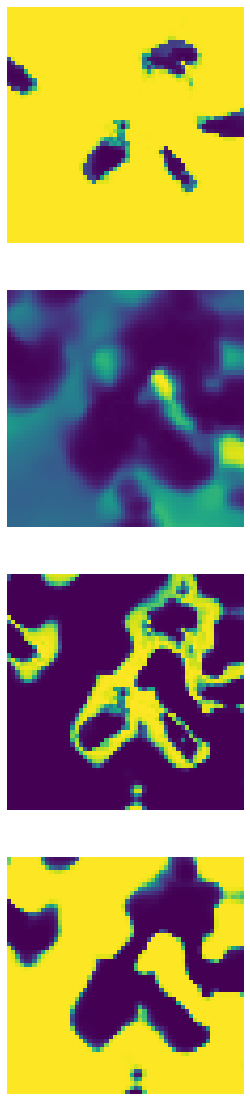

In [285]:
get_maps(1812,'fid2', 8, ['xHII', 'T', 'xHeII', 'xHeIII'], axis=0)

In [170]:
df_no_dust.keys()

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'aStar', 'HaloRadii', 'f_esc', 'per_freq',
       'per_source', 'emitted_photons', 'escaped_photons', 'frequencies',
       'n_iterations', 'StarMass'],
      dtype='object')

In [217]:
df_no_dust['Q0/HaloMass']=df_no_dust['Q0']/df_no_dust['HaloMass']
df_no_dust['R_v^3/HaloMass']=df_no_dust['HaloRadii']**3/df_no_dust['HaloMass']
df_no_dust['StarMass']= df_no_dust['HaloMass']*df_no_dust['FractionStars']*1e4

In [224]:
halo_props = ['FractionDust', 'aStar', 'Q0/HaloMass', 'R_v^3/HaloMass']

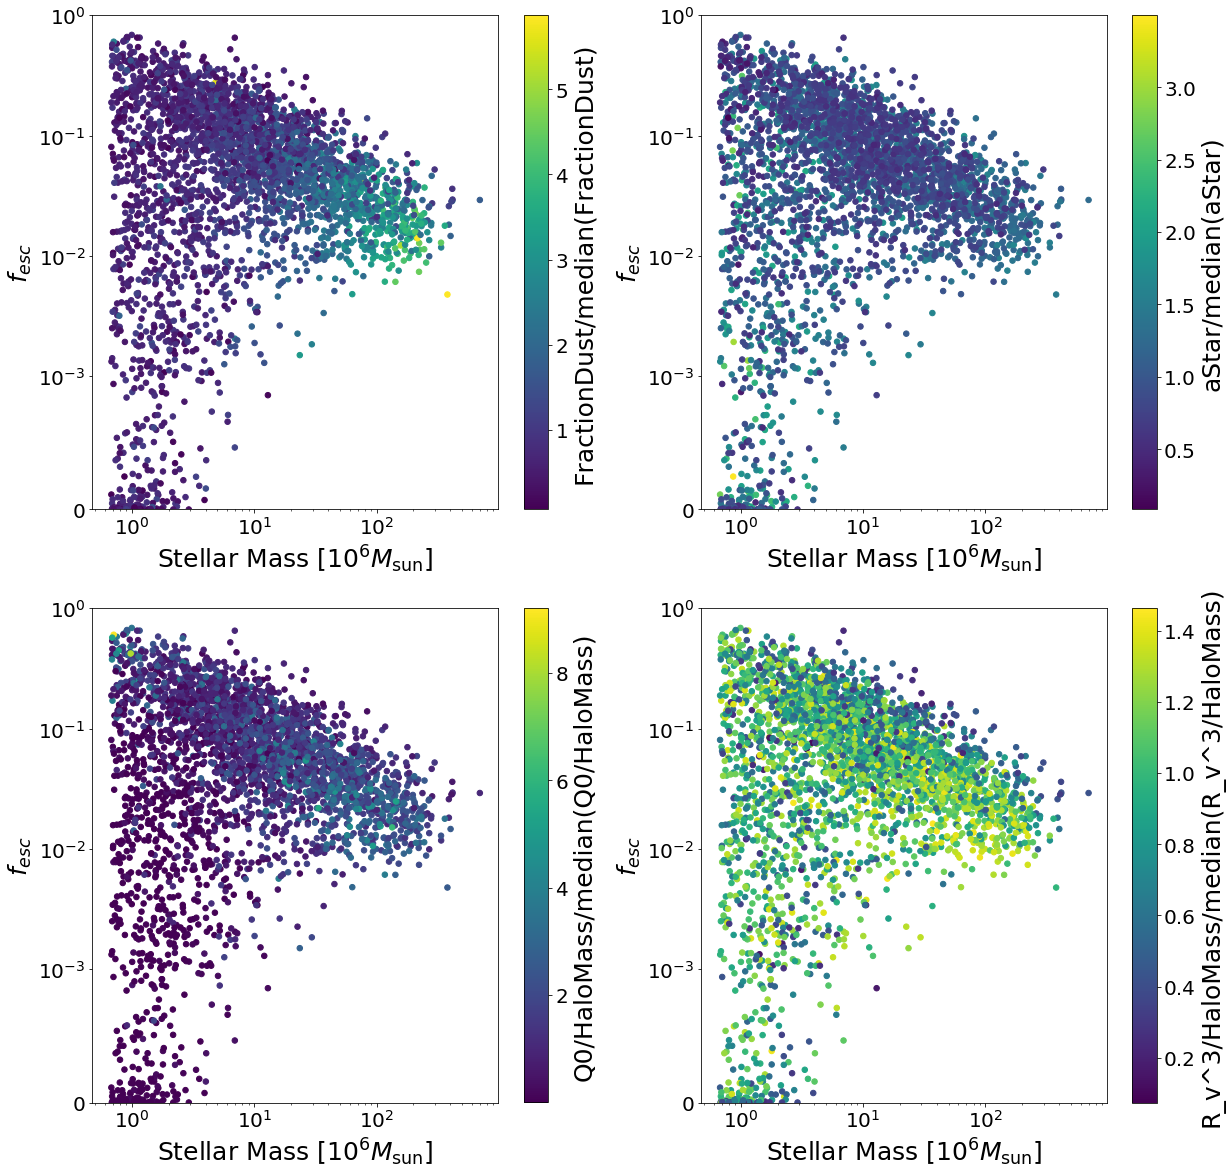

In [227]:
plot_color_coded(df_no_dust, halo_props, x_axis='StarMass')

In [228]:
from crashpy.utilities import crashMemMap

In [245]:
a = crashMemMap(get_simulation_path(7085,'fid2', 6), 'all')

In [248]:
for element in a:
    print(element.shape)

(84, 84, 84)
(84, 84, 84)
(84, 84, 84)
(84, 84, 84)
